In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import qutip as qt
def annihilation(d):
    return np.diag(np.sqrt(np.arange(1, d)), 1)

def creation(d):
    return annihilation(d).T

In [96]:
# Parameters
def state_index(index,dim):
    n,k = index
    N,K = dim
    return n*K+k
def Hamiltonian(omega3):
    d1 = d2 = 5
    omega1 = 5.22 * 2 * np.pi
    delta1 =0  * 2 * np.pi
    delta3 = -0.1 * 2 * np.pi
    g13 = 0.3 * 2 * np.pi

    # Create operators
    a1, a3 = [annihilation(d) for d in (d1, d2)]
    a1d, a3d = [creation(d) for d in (d1, d2)]
    I1,  I3 = [np.eye(d) for d in (d1, d2)]

    # Construct Hamiltonians
    H1 = omega1 * a1d @ a1 + delta1/2 * a1d @ a1d @ a1 @ a1
    H3 = omega3 * a3d @ a3 + delta3/2 * a3d @ a3d @ a3 @ a3

    H1 = np.kron(I3, H1)
    H3 = np.kron(H3, I1)

    Hint13 = g13 * np.kron(a3d + a3,  a1d + a1)

    # Total Hamiltonian
    H = H1 + H3 + Hint13
    
    Hc = np.kron(a3d + a3,  I1)
    noise_op = np.kron(a3d @ a3,  I1)
    return H, Hc, noise_op
 

In [97]:
def find_optimal_k(A, B, D):
    # Define a large initial minimum difference
    min_diff = float('inf')
    optimal_k = None
    
    # Iterate over a range of possible k values
    # The range can be adjusted based on expected size of k or other insights you have about your problem
    for k in range(-1000, 1000):
        # Calculate the difference for this value of k
        diff = abs(A - (B + k * D))
        
        # If this is the smallest difference we've found so far, update min_diff and optimal_k
        if diff < min_diff:
            min_diff = diff
            optimal_k = k
            
    return optimal_k
# Function to calculate overlap (you might use inner product, fidelity, etc.)
def calculate_overlap(state1, state2):
    return abs((state1.dag() * state2))**2


In [ ]:
def calculate_floquet_energies(A, omega,omega3):
    # Define system parameters
    dim = [5, 5]
    H0, Hc, noise_op = Hamiltonian(omega3)
    
    index01 = state_index([0,1], dim)
    
    omega1 = np.diag(H0)[index01]

    H0 = qt.Qobj(H0)
    Hc = qt.Qobj(Hc)

    T = (2 * np.pi) / omega

    # Define the Hamiltonian
    H = [H0, [Hc, lambda t, args: A * np.cos(omega * t)]]

    # Set up the Floquet solver
    floquet_basis = qt.FloquetBasis(H, T,)

    # Compute Floquet modes and energies
    f_modes = floquet_basis.mode(0)
    f_energies = floquet_basis.e_quasi

    # Define basis states
    basis_states = [qt.basis(H0.dims[0][0], 0), 
                    qt.basis(H0.dims[0][0], index01)]

    # Find Floquet states with maximum overlap
    max_overlap_indices = [-1] * 2
    max_overlaps = [0] * 2
    for f_index, f_state in enumerate(f_modes):
        for b_index, b_state in enumerate(basis_states):
            overlap = calculate_overlap(f_state, b_state)
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index

    # Calculate energies
    energy00 = f_energies[max_overlap_indices[0]] / (2 * np.pi)

    energy01 = f_energies[max_overlap_indices[1]] / (2 * np.pi)
    k = find_optimal_k(omega1 / (2 * np.pi), energy01, omega / (2 * np.pi))
    energy01 = energy01 + k * omega / (2 * np.pi) - energy00

    return energy01*2*np.pi, f_modes[max_overlap_indices[0]], f_modes[max_overlap_indices[1]],max_overlap_indices

In [ ]:
def calculate_derivatives(A, omegad,omega3):
    energy01, _, _,_ = calculate_floquet_energies(A, omegad, omega3)
    epsilon = 1e-6
    energy01_, _, _,_ = calculate_floquet_energies(A, omegad, omega3 + epsilon)
    der1 = (energy01_ - energy01) / epsilon
    return der1, omegad/2/np.pi
from scipy.optimize import minimize_scalar


omega3 = 6.135*2*np.pi
A = 0.002*2*np.pi
# omegad = np.linspace(3.3846*2*np.pi,3.3848*2*np.pi,50)
omegad = 6.18*2*np.pi
der, _ = calculate_derivatives(A, omegad,omega3)
def objective(omegad):
    der, _ = calculate_derivatives(A, omegad, omega3)
    return abs(der)

result = minimize_scalar(objective, bounds=(omega3, 6.3*2*np.pi), method='bounded')
optimal_omegad = result.x
print(f"Optimal omegad: {optimal_omegad/2/np.pi}")


Optimal omegad: 6.214130596608725


In [203]:
_, dressed_00, dressed_01,index = calculate_floquet_energies(A, optimal_omegad,omega3)

In [204]:
H0, Hc, noise_op = Hamiltonian(omega3)
H0 = qt.Qobj(H0)
Hc = qt.Qobj(Hc)
noise_op = qt.Qobj(noise_op)
T     = 2*np.pi / optimal_omegad
tlist  = np.linspace(0.0, 1000 * T, 1001)
psi0   = 1/np.sqrt(2)*(dressed_01 + dressed_00 )
H = [H0, [Hc, lambda t, args: A * np.cos(optimal_omegad * t)]]

In [205]:
T     = 2*np.pi / optimal_omegad
tlist  = np.linspace(0.0, 1000 * T, 1001)
psi0   = 1/np.sqrt(2)*(dressed_01 + dressed_00 )
floquet_basis = qt.FloquetBasis(H, T,)
# Compute Floquet modes and energies
f_modes = floquet_basis.mode(0)

In [206]:
# noise power spectrum
gamma1 = 0.01
def noise_spectrum(w):
    return   4*gamma1 * (w>=0)
    # return   gamma1 * np.abs(w)**2 * (w>0)
    
temperature = 0e-3 # unit K 
h = 6.626e-34 
kB = 1.38e-23 
w_th = temperature * (kB / h) * 2 * np.pi * 1e-9    

In [207]:
from auxiliary_func import *
A,w = obtain_Aw(H, [opt], [noise_spectrum], T, w_th)
w.to_array()[index[0],index[1]]


(1.6430638069029894e-09+0j)

In [208]:
A.to_array()[index[0],index[1]]

(0.0017963485275833495-2.335044633878793e-26j)

In [200]:
from auxiliary_func import *
A,w = obtain_Aw(H, [opt], [noise_spectrum], T, w_th)
w.to_array()[index[0],index[1]]


(0.0017239970216925797+0j)

(1.3110032303669855e-34-1.4754734217129043e-52j)

In [108]:
sigmax = dressed_00*dressed_01.dag() + dressed_01*dressed_00.dag()
sigmay = -1j*(dressed_00*dressed_01.dag() - dressed_01*dressed_00.dag())
sigmaz =  dressed_01*dressed_01.dag() - dressed_00*dressed_00.dag()

In [109]:
opt = noise_op
output= qt.fmmesolve(
    H, psi0, tlist, [opt],
    spectra_cb=[noise_spectrum], T=T, w_th=w_th,
     options={"store_floquet_states": True}
)

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.04s. Est. time left: 00:00:00:00
30.0%. Run time:   0.05s. Est. time left: 00:00:00:00
40.0%. Run time:   0.07s. Est. time left: 00:00:00:00
50.0%. Run time:   0.10s. Est. time left: 00:00:00:00
60.0%. Run time:   0.13s. Est. time left: 00:00:00:00
70.0%. Run time:   0.18s. Est. time left: 00:00:00:00
80.0%. Run time:   0.27s. Est. time left: 00:00:00:00
90.0%. Run time:   0.29s. Est. time left: 00:00:00:00
100.0%. Run time:   0.32s. Est. time left: 00:00:00:00
Total run time:   0.32s


In [110]:
from auxiliary_func import obtain_Aw
A,w = obtain_Aw(H, [opt], [noise_spectrum], T, w_th)

In [111]:
w.to_array()

array([[0.00000000e+00+0.j, 1.94507920e-01+0.j, 5.92418230e-01+0.j,
        1.54060114e+00+0.j, 2.98694663e+00+0.j, 8.63375866e-03+0.j,
        1.57364273e-01+0.j, 6.98375513e-01+0.j, 9.59925502e-03+0.j,
        1.68420318e+00+0.j, 3.13656753e+00+0.j, 3.43050965e-03+0.j,
        2.27380869e-01+0.j, 8.19858976e-01+0.j, 1.82799118e+00+0.j,
        3.28536203e+00+0.j, 1.57108997e-02+0.j, 2.60944808e-01+0.j,
        3.46849958e-02+0.j, 1.06118589e+00+0.j, 2.66102577e+00+0.j,
        1.06344836e-01+0.j, 4.45813438e-01+0.j, 1.41520289e+00+0.j,
        2.83642429e+00+0.j],
       [1.94507920e-01+0.j, 0.00000000e+00+0.j, 1.08015146e-01+0.j,
        6.40286472e-01+0.j, 1.65700740e+00+0.j, 1.21182312e-01+0.j,
        1.96593459e-03+0.j, 1.55755036e-01+0.j, 1.17686549e-01+0.j,
        7.34000029e-01+0.j, 1.76891384e+00+0.j, 1.46275627e-01+0.j,
        1.28265556e-03+0.j, 2.15695339e-01+0.j, 8.29924133e-01+0.j,
        1.88108424e+00+0.j, 9.96585299e-02+0.j, 4.87162837e-03+0.j,
        3.93467151e

In [112]:
w.to_array()

array([[0.00000000e+00+0.j, 1.94507920e-01+0.j, 5.92418230e-01+0.j,
        1.54060114e+00+0.j, 2.98694663e+00+0.j, 8.63375866e-03+0.j,
        1.57364273e-01+0.j, 6.98375513e-01+0.j, 9.59925502e-03+0.j,
        1.68420318e+00+0.j, 3.13656753e+00+0.j, 3.43050965e-03+0.j,
        2.27380869e-01+0.j, 8.19858976e-01+0.j, 1.82799118e+00+0.j,
        3.28536203e+00+0.j, 1.57108997e-02+0.j, 2.60944808e-01+0.j,
        3.46849958e-02+0.j, 1.06118589e+00+0.j, 2.66102577e+00+0.j,
        1.06344836e-01+0.j, 4.45813438e-01+0.j, 1.41520289e+00+0.j,
        2.83642429e+00+0.j],
       [1.94507920e-01+0.j, 0.00000000e+00+0.j, 1.08015146e-01+0.j,
        6.40286472e-01+0.j, 1.65700740e+00+0.j, 1.21182312e-01+0.j,
        1.96593459e-03+0.j, 1.55755036e-01+0.j, 1.17686549e-01+0.j,
        7.34000029e-01+0.j, 1.76891384e+00+0.j, 1.46275627e-01+0.j,
        1.28265556e-03+0.j, 2.15695339e-01+0.j, 8.29924133e-01+0.j,
        1.88108424e+00+0.j, 9.96585299e-02+0.j, 4.87162837e-03+0.j,
        3.93467151e

In [64]:
A.to_array()

array([[0.00000000e+00+0.00000000e+00j, 9.44620178e-04-6.73644467e-26j,
        2.87166218e-06+1.45259140e-26j, 1.66088649e-09+1.05986964e-32j,
        1.57223532e-12+7.92446340e-34j, 1.46237424e-08+6.69846247e-30j,
        4.64971258e-08-4.53119194e-29j, 4.31128708e-09-1.72502896e-31j,
        9.79420915e-04-9.84616400e-26j, 8.09713855e-13+1.14235064e-34j,
        2.94951529e-15+9.80362367e-37j, 1.23750998e-11-3.95235300e-32j,
        1.31727890e-08-1.32931750e-30j, 1.46564722e-12-2.49846958e-34j,
        1.92926616e-17+3.20431066e-39j, 1.65005943e-16-9.69112340e-38j,
        5.88820841e-02-1.33358819e-24j, 6.84744780e-06+1.68135682e-27j,
        2.24796049e-07-1.67880647e-27j, 1.07048343e-05-2.33269331e-28j,
        3.13220426e-10-5.57332167e-32j, 1.36570766e-05-6.17344580e-25j,
        1.37673342e-04-2.45687249e-27j, 1.00404098e-08+5.54017589e-31j,
        1.58223261e-10+2.12354344e-32j],
       [6.11500539e-12-9.01585857e-30j, 0.00000000e+00+0.00000000e+00j,
        2.48850316e-13-

In [17]:
p_x = np.zeros(tlist.shape, dtype=np.complex128)
p_y = np.zeros(tlist.shape, dtype=np.complex128)
p_z = np.zeros(tlist.shape, dtype=np.complex128)
for idx, t in enumerate(tlist):
    psi_t = output.floquet_states[idx]
    p_x[idx] = qt.expect(floquet_basis.to_floquet_basis(sigmax), psi_t)
    p_y[idx] = qt.expect(floquet_basis.to_floquet_basis(sigmay), psi_t)
    p_z[idx] = qt.expect(floquet_basis.to_floquet_basis(sigmaz), psi_t)

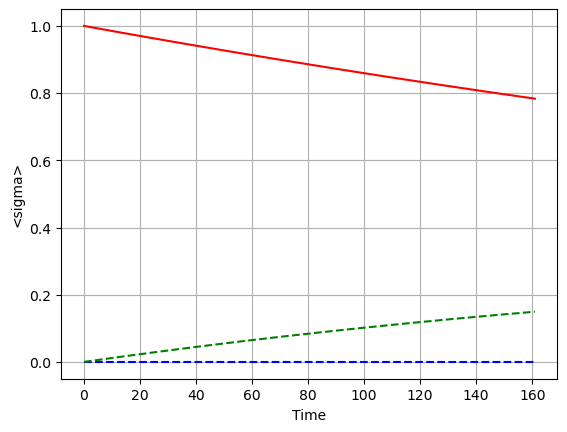

In [18]:
plt.plot(tlist, np.real(p_x), 'r-')
plt.plot(tlist, np.real(p_y), 'b--')
plt.plot(tlist, np.real(p_z), 'g--')
plt.xlabel('Time')
plt.ylabel('<sigma>')
plt.grid()
plt.show()

In [19]:
from scipy.optimize import curve_fit
def model_function(t, a, c, tau):
    return a*np.exp(-t / tau) + c
popt_x, pcov = curve_fit(model_function, tlist, np.real(p_x), p0=[0.5, 0.5, 1], maxfev=50000)
a_fit, c_fit, tau_fit_z = popt_x
print(f"Fitted parameters: a = {a_fit:.4f}, c = {c_fit:.4f}, tau = {tau_fit_z:.4f}")


Fitted parameters: a = 1.0000, c = 0.0000, tau = 659.5340


In [20]:
from scipy.optimize import curve_fit
def model_function(t, a, c, tau):
    return a*np.exp(-t / tau) + c
popt_x, pcov = curve_fit(model_function, tlist, np.real(p_x), p0=[0.5, 0.5, 1], maxfev=50000)
a_fit, c_fit, tau_fit_z = popt_x
print(f"Fitted parameters: a = {a_fit:.4f}, c = {c_fit:.4f}, tau = {tau_fit_z:.4f}")


Fitted parameters: a = 1.0000, c = 0.0000, tau = 659.5340
